In [1]:
import pandas as pd
import numpy as np
import pickle

aisle = pd.read_csv('C:/Users/lyn02/Desktop/CMPE255 Project/Raw Data/aisles.csv')
department = pd.read_csv('C:/Users/lyn02/Desktop/CMPE255 Project/Raw Data/departments.csv')
order_products_prior = pd.read_csv('C:/Users/lyn02/Desktop/CMPE255 Project/Raw Data/order_products__prior.csv')
order_products_train = pd.read_csv('C:/Users/lyn02/Desktop/CMPE255 Project/Raw Data/order_products__train.csv')
orders = pd.read_csv('C:/Users/lyn02/Desktop/CMPE255 Project/Raw Data/orders.csv')
products = pd.read_csv('C:/Users/lyn02/Desktop/CMPE255 Project/Raw Data/products.csv')
new_aisle_match = pd.read_csv('C:/Users/lyn02/Desktop/CMPE255 Project/Raw Data/new_aisle_matchV2.csv');

In [2]:
# Take out orderID and productID from both train and prior table and merge them into one order_products_id table
order_products_id1 = order_products_train[['order_id','product_id']]
order_products_id2 = order_products_prior[['order_id','product_id']]
order_products_id = order_products_id1.append(order_products_id2, ignore_index=True)
#order_products_id

In [3]:
# take out orderID and userID from orders table
order_user_id = orders[['order_id','user_id']]
#order_user_id

In [4]:
# to see how many orders each user has altogether
user_order_count = order_user_id[['user_id','order_id']]
user_order_count = user_order_count.groupby(['user_id']).agg({'order_id': 'count'}).reset_index()
user_order_count.rename(columns={"order_id": "order_count"}, inplace=True)
#user_order_count

# CUSTOMER SELECTION

In [5]:
# If we assume a customer does grocery shopping at least once every other week
# Among 206K customers, only 40K customers have transaction count more than 24
# It would be better to use customers who has been shopping for a year for customer segregation since users with less
# than this tx count might only introduce unnecessary noise to the data
user_order_count_annual = user_order_count[user_order_count['order_count'] > 24]
#user_order_count_annual

In [6]:
#combine order_products and products table to see what aisle each product belongs for each order
order_product_aisle = order_products_id.merge(products,on='product_id')
#order_product_aisle

In [7]:
# to see which aisle is most popular
pd.set_option('display.max_rows', 134)
aisle_product_count = order_product_aisle.groupby('aisle_id').agg({'product_id': 'count'})
aisle_product_count = aisle_product_count.reset_index()
aisle_product_count = aisle_product_count.sort_values('product_id', ascending=False)
aisle_product_count = aisle_product_count.merge(aisle,on='aisle_id')
aisle_product_count.rename(columns={"product_id": "product_purchase_count"}, inplace=True)
total_product_count = sum(aisle_product_count['product_purchase_count'])
aisle_product_count['percentage'] = aisle_product_count['product_purchase_count']/total_product_count
#aisle_product_count
#aisle_product_count.to_csv(r'C:\Users\lyn02\Desktop\CMPE255 Project\aisle_product_count.csv', index = True)

In [8]:
#from order_product_aisle table, only select orderID and aisleID to aggregate some data since we only deal with 
#aisle level granularity
#In addition, count of products from each aisle for each order is kept
order_aisle_id = order_product_aisle[['order_id','aisle_id']]
order_aisle_id['aisle_id2'] = order_product_aisle['aisle_id']
#order_aisle_id
order_aisle_count = order_aisle_id.groupby(['order_id','aisle_id']).agg({'aisle_id2': 'count'}).reset_index()
order_aisle_count.rename(columns={"aisle_id2": "product_count"}, inplace=True)
#order_aisle_count
#print(sum(order_aisle_count['count']))

<ipython-input-8-79b968723b9d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_aisle_id['aisle_id2'] = order_product_aisle['aisle_id']


In [9]:
#join order_user_id table and order_aisle_count table to see which order belongs to which user
order_user_aisle = order_aisle_count.merge(order_user_id, on='order_id')
#order_user_aisle

In [10]:
#from order_user_aisle table, take out orderID and group by user_id, aisle_id
user_aisle_id = order_user_aisle[['user_id','aisle_id','product_count']]
user_aisle_count = user_aisle_id.groupby(['user_id','aisle_id']).agg({'product_count': 'sum'}).reset_index()
#user_aisle_count

In [11]:
# user_aisle_count right join user_order_count_annual 
user_aisle_order_count_annual = user_aisle_count.merge(user_order_count_annual, how='right',on='user_id')
#user_aisle_order_count_annual

In [12]:

# get total product count for each user each aisle
user_aisle_order_count_annual['total_prod_count'] = user_aisle_order_count_annual['product_count']*user_aisle_order_count_annual['order_count']
user_aisle_order_count_annual
# look at what percentage of users would buy products from each aisle
aisle_user = user_aisle_order_count_annual[['aisle_id','user_id','total_prod_count']]
aisle_user = aisle_user.groupby(['aisle_id']).agg({'user_id':'count','total_prod_count': 'sum'}).reset_index()
aisle_user.rename(columns={"user_id": 'user_count'}, inplace=True)
aisle_user = aisle_user.sort_values('user_count', ascending=False)
aisle_user = aisle_user.merge(aisle, how='left', on='aisle_id')
total_user_count = 40211 # from previous step, total count of customers with more than 25 tx
aisle_user['user_percent'] = aisle_user['user_count'] / total_user_count
total_prod_count = sum(aisle_user['total_prod_count'])
aisle_user['prod_percent'] = aisle_user['total_prod_count'] / total_prod_count
#aisle_user

In [13]:
#aisle_user[['aisle','user_percent']]

# Aisle Grouping

In [14]:
#aisle grouping
new_user_aisle_order_count_annual = user_aisle_order_count_annual.merge(new_aisle_match, how='inner', on='aisle_id')
#new_user_aisle_order_count_annual

In [15]:
new_user_aisle_order_count_annual = new_user_aisle_order_count_annual[['user_id','new_aisle_ID','product_count','order_count','total_prod_count']]
new_user_aisle_order_count_annual = new_user_aisle_order_count_annual.groupby(['user_id','new_aisle_ID']).agg({'product_count':'sum','order_count':'sum','total_prod_count': 'sum'}).reset_index()
#new_user_aisle_order_count_annual.rename(columns={"new_aisle_ID": 'aisle_id'}, inplace=True)
#new_user_aisle_order_count_annual

In [16]:
#print(sum(new_user_aisle_order_count_annual['total_prod_count']))
#print(sum(user_aisle_order_count_annual['total_prod_count']))

In [17]:
# new_aisle_match = pd.read_csv('C:/Users/lyn02/Desktop/CMPE255 Project/Raw Data/new_aisle_match.csv');
# look at what percentage of users would buy products from each aisle
aisle_user = new_user_aisle_order_count_annual[['new_aisle_ID','user_id','total_prod_count']]
aisle_user = aisle_user.groupby(['new_aisle_ID']).agg({'user_id':'count','total_prod_count': 'sum'}).reset_index()
aisle_user.rename(columns={"user_id": 'user_count'}, inplace=True)
aisle_user = aisle_user.sort_values('user_count', ascending=False)
aisle_user = aisle_user.merge(new_aisle_match, how='left', on='new_aisle_ID')
total_user_count = 40211 # from previous step, total count of customers with more than 24 tx
aisle_user['user_percent'] = aisle_user['user_count'] / total_user_count
total_prod_count = sum(aisle_user['total_prod_count'])
aisle_user['prod_percent'] = aisle_user['total_prod_count'] / total_prod_count
aisle_user = aisle_user[['new_aisle_ID', 'user_count', 'total_prod_count','aisle','user_percent','prod_percent']]
aisle_user.drop_duplicates(inplace=True)
#aisle_user

In [18]:
#aisle_user[['aisle','user_percent']]

In [19]:
#print(sum(aisle_user['total_prod_count']))

# aisle filtering

In [20]:
# if we assume that if more than 70% of the users buy from an aisle, it is an essential product aisle
# we can exclude those aisles from the data since they wouldn't help much in differentiating customers into 
# different groups

non_essential_aisle = aisle_user.loc[(aisle_user['user_percent'] < 0.7) & (aisle_user['new_aisle_ID'] != 55), 'new_aisle_ID']
#non_essential_aisle = aisle_user.loc[(aisle_user['new_aisle_ID'] < 0.7), 'aisle_id']
non_essential_aisle
user_aisle_order_count_annual_nesse = new_user_aisle_order_count_annual.merge(non_essential_aisle, how='inner', on='new_aisle_ID')
#user_aisle_order_count_annual_nesse

In [21]:
# divide product count by order count to get for aisle, how many products on average each customer would buy per order
user_aisle_order_count_annual_nesse['avg'] = user_aisle_order_count_annual_nesse['product_count']/user_aisle_order_count_annual_nesse['order_count']
user_aisle_avgCount_annual = user_aisle_order_count_annual_nesse[['user_id','new_aisle_ID','avg']]
#user_aisle_avgCount_annual

In [22]:
data = pd.pivot_table(user_aisle_avgCount_annual, values='avg', index=['user_id'],columns=['new_aisle_ID'], aggfunc=np.sum, fill_value=0)
data.reset_index(inplace=True)
# index match
index_match = data['user_id']
#index_match
data.set_index('user_id', inplace=True)

data

new_aisle_ID,8,9,10,11,12,15,16,17,18,19,...,71,72,73,74,75,76,77,78,79,80
user_id,,,,,,,,,,,,,,,,,,,,,
17,0.878049,0.000000,0.756098,0.000000,0.341463,0.292683,0.000000,0.073171,0.000000,0.048780,...,0.0,0.0,0.000000,0.000000,0.780488,0.000000,0.000000,0.073171,0.0,0.0
21,0.382353,0.029412,0.764706,0.382353,0.073529,0.000000,0.147059,0.117647,0.029412,0.000000,...,0.0,0.0,0.117647,0.000000,0.088235,0.000000,0.000000,0.029412,0.0,0.0
27,1.134146,0.378049,0.000000,0.036585,0.000000,0.000000,1.707317,0.097561,0.000000,0.012195,...,0.0,0.0,0.000000,0.000000,0.000000,0.012195,0.000000,0.000000,0.0,0.0
28,0.040000,0.160000,0.120000,0.120000,0.120000,0.000000,0.000000,0.120000,0.040000,0.000000,...,0.0,0.0,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
36,0.421053,0.000000,0.000000,0.105263,0.000000,0.000000,0.000000,0.026316,0.052632,0.000000,...,0.0,0.0,0.763158,0.000000,0.000000,0.000000,0.763158,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206187,0.114286,0.057143,0.000000,0.028571,0.000000,0.000000,0.000000,0.057143,0.000000,0.028571,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
206193,0.023810,0.309524,0.238095,0.095238,0.119048,0.023810,0.000000,0.047619,0.023810,0.047619,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
206201,0.212121,0.000000,0.454545,0.242424,0.106061,0.212121,0.030303,0.030303,0.000000,0.090909,...,0.0,0.0,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.0,0.0


# Principal component analysis for dimension reduction

In [23]:
# principal component analysis for dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca_50 = pca.fit_transform(data)
np.sum(pca.explained_variance_ratio_)

0.9382742693582159

In [24]:
pca = PCA(n_components=34)
pca_34 = pca.fit_transform(data)
np.sum(pca.explained_variance_ratio_)

0.9047129866332769

In [25]:
pca_34_90percent = pd.DataFrame(pca_34)
#pca_34_90percent

# k-Means Clustering

In [26]:
# k means clustering on pca_data
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#X_train, x_test = train_test_split(pca_34_90percent, test_size = 0.3, random_state=42)

Text(0, 0.5, 'inertia')

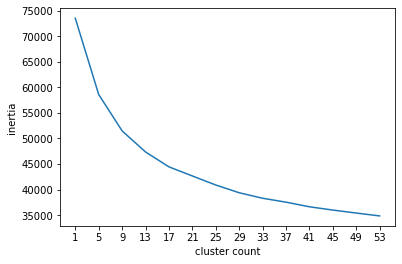

In [53]:
# elbow analysis
df = pd.DataFrame(columns = ['cluster','inertia'])
for n in range(1, 56, 4):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(pca_34_90percent)
    df = df.append({'cluster':n, 'inertia': kmeans.inertia_}, ignore_index=True)

plt.plot(df['cluster'],df['inertia'])
plt.xticks(np.arange(1, 56, 4.0))
plt.xlabel('cluster count')
plt.ylabel('inertia')

C:\Users\lyn02\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


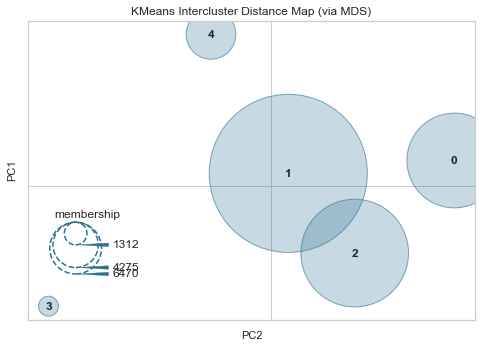

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [28]:
from yellowbrick.cluster import InterclusterDistance
#Intercluster distance analysis
# the closer to centers are in the visualization, the closer they are in the original feature space
# cluster size depends on number of instances belongs to them --> gives a sense of relative importance of clusters
# overlapping clusters do not mean they overlap in the original feature space
modelKmean = KMeans(n_clusters=5, random_state=42)
visualizer = InterclusterDistance(modelKmean)
visualizer.fit(pca_34_90percent)
visualizer.show()

In [31]:
# save the model to disk
modelKmean.fit(pca_34_90percent)
filename = 'customer_segmentation_model.sav'
pickle.dump(modelKmean, open(filename, 'wb'))

In [32]:
# from result above, it looks like 5 clusters is a good separation of the data
y_kmean = pd.DataFrame(modelKmean.predict(pca_34_90percent))
result = pca_34_90percent.copy(deep=True)
result.reset_index(inplace=True)
result.insert(1,'label',y_kmean)
result = result.rename(columns = {'index':'X'})
result = result[['X','label']]
index_match = pd.DataFrame(index_match)
index_match.reset_index(inplace=True)
index_match = index_match.rename(columns = {'index':'X'})

result = index_match.merge(result, on = 'X')
result = result[['user_id','label']]
# export customer classification labels
result.to_csv(r'C:\Users\lyn02\Desktop\CMPE255 Project\customer_classificationV3kmean.csv', index = True)
# export to excel for further analysis
kmeanResult = user_aisle_avgCount_annual.merge(result, how='inner', on='user_id')
kmeanResult1 = kmeanResult[kmeanResult['label']==0]
kmeanResult2 = kmeanResult[kmeanResult['label']>0]
kmeanResult1.to_csv(r'C:\Users\lyn02\Desktop\CMPE255 Project\kmean1.csv', index = True)
kmeanResult2.to_csv(r'C:\Users\lyn02\Desktop\CMPE255 Project\kmean2.csv', index = True)

# Agglomeartive Clustering

In [33]:
# Agglomerative Clustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

np.set_printoptions(threshold=np.inf)
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0]) # n_samples - 1 = 1500-1=1499
    n_samples = len(model.labels_) # 1500
    for i, merge in enumerate(model.children_):
        current_count = 0
        
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    

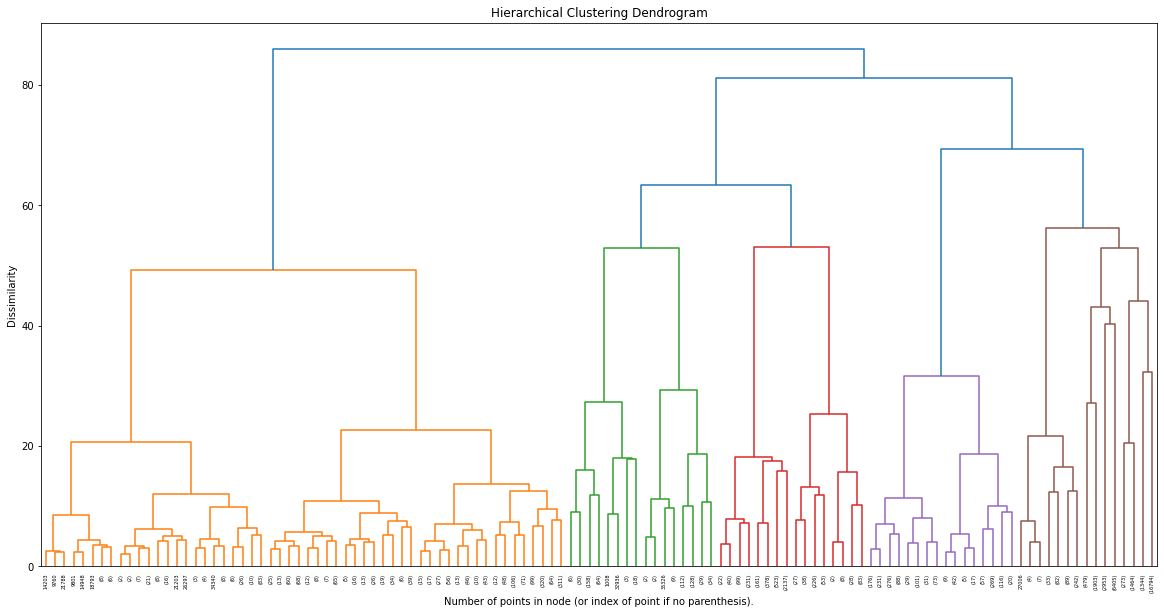

In [46]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(pca_34_90percent)

# plot the top three levels of the dendrogram
plt.figure(figsize=(20,10))
plot_dendrogram(model, truncate_mode='level', p=6)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Dissimilarity")

plt.show()

In [67]:
# clustering result from agglomerative clustering
model2 = AgglomerativeClustering(n_clusters=5)
model2.fit(pca_34_90percent)
y_agg = pd.DataFrame(model2.labels_)
result_agg = pca_34_90percent.copy(deep=True)
result_agg.reset_index(inplace=True)
result_agg.insert(1,'label',y_agg)
result_agg = result_agg.rename(columns = {'index':'X'})
result_agg = result_agg[['X','label']]
result_agg = index_match.merge(result_agg, on = 'X')
result_agg = result_agg[['user_id','label']]
result_agg.to_csv(r'C:\Users\lyn02\Desktop\CMPE255 Project\customer_classificationAGG.csv', index = True)
#result_agg

agg_result = user_aisle_avgCount_annual.merge(result_agg, how='inner', on='user_id')
agg_result.to_csv(r'C:\Users\lyn02\Desktop\CMPE255 Project\agg.csv', index = True)

agg_result1 = agg_result[agg_result['label']==0]
agg_result2 = agg_result[agg_result['label']>0]
agg_result1.to_csv(r'C:\Users\lyn02\Desktop\CMPE255 Project\agg1.csv', index = True)
agg_result2.to_csv(r'C:\Users\lyn02\Desktop\CMPE255 Project\agg2.csv', index = True)

,X,label
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
40155,40155,0
40156,40156,0
40157,40157,0
40158,40158,0
